![](Rydiqule_Logo_Transparent_300.png)

# Calculating SNR

This notebook can be downloaded [here](https://github.com/QTC-UMD/rydiqule/blob/main/docs/source/examples/Calculate_SNR.ipynb).

Rydiqule contains the function `rydiqule.get_snr()` function that will take a Sensor or Cell and calculate the expected SNR for one axis of the solve. Below we demonstrate the use of this function to numerically confirm the analytic results of Meyer et. al. PRA 104, 043103 (2021) Eqs. 12 & 13:

$$ \Omega_p^\text{(opt)}\approx\sqrt{\Gamma(2\gamma+\Gamma_r+\Gamma_c)}$$

$$ \Omega_c^\text{(opt)}\approx\sqrt{2}\Omega_p^\text{(opt)}$$

These show the optical probe and coupling Rabi frequencies for resolving Rydberg state shifts in a 2-color Rydberg EIT measurement, in an optically-thin with no Doppler broadening.

In [1]:
import numpy as np
import rydiqule as rq
import matplotlib.pyplot as plt

Manually define representative kappa and eta constants for a Rb85 sensor. These are necessary to find the SNR in experimental units and must be supplied by the user when calculating using a Sensor. If using a Cell, these constants are automatically calculated and do not need to be passed to `get_snr`.

The definition of these numerical factors is found in Meyer et. al. PRA 104, 043103 (2021) Eqs. 5 & 7.

$$ \kappa = \frac{\omega_p n \mu^2}{2c\epsilon_0\hbar} $$

$$ \eta = \sqrt{\frac{\omega\mu^2}{2c\epsilon_0\hbar A}}$$

In [2]:
kappa = 28974.8787
eta = 0.00135882
probe_freq = 2.416e9

## 1D Optimum

Here we demonstrate calculating the SNR for resolving a phase shift due to an RF Rydberg coupling vs probe Rabi frequency. We have chosen a far-detuned RF coupling to ensure Stark shifts are linear.

In [3]:
##Set up a simplified Rb Sensor
basis_size = 4
Rb_sensor = rq.Sensor(basis_size)
Rb_sensor.set_experiment_values(probe_freq = probe_freq,
                              kappa = kappa, eta = eta, cell_length = .000001)

red_rabi = np.linspace(0.1,6,100)
blue_rabi = np.linspace(0.1,4,101)
blue_rabi_1 = 1
my_step = np.array([1, 1.1])
probe = {'states': (0,1), 'rabi_frequency': red_rabi, 'detuning': 0, 'label': 'probe'}
couple = {'states': (1,2), 'rabi_frequency':blue_rabi_1, 'detuning': 0, 'label':'couple'}
rf = {'states': (2,3), 'rabi_frequency': my_step, 'detuning':20, 'label': 'rf'}

Rb_sensor.add_couplings(probe,couple, rf)

#simplify the gamma matrix to match predictions
gam = np.zeros((basis_size, basis_size))
gam[2,0] = 0.1
gam[3,0] = 0.01
gam[1,0] = 6.0
Rb_sensor.set_gamma_matrix(gam)

To calculate the SNR vs a specific parameter, that parameter must be list-like with at least two elements. So calculated vs RF Rabi frequency, we have specified two Rabi frequency values very close to each other to measure the local linear sensitivity. More values can be added to this list to see if sensitivity changes for larger changes in the parameter, which indicates nonlinear response.

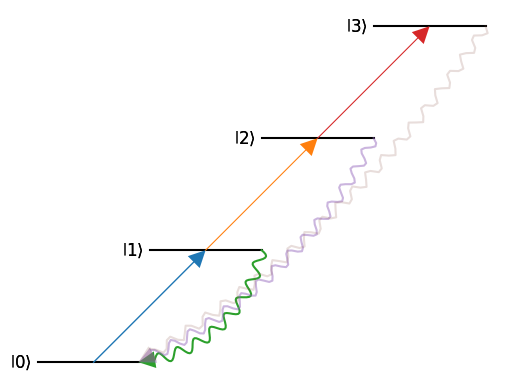

In [4]:
rq.draw_diagram(Rb_sensor)

We call `get_snr` with the Sensor to calculate with, the label of the swept parameter to calculate SNR against, the tuple of the probing transition to get measurable parameters from, which quadrature the probing field is being detected in, and the kappa and eta numerical factors.

In [5]:
snrs, param_mesh = rq.get_snr(Rb_sensor, param_label = 'rf_rabi_frequency',
                            phase_quadrature = True)

Using `Sensor.axis_labels()` we can identify which axis rydiqule has used for the swept parameters. This allows us to correctly index out the appropriate solutions for analysis. In particular, we need to index the sensitivity axis to get the sensitivity at the second RF Rabi frequency in the list (relative to the first).

In [6]:
#print the axis labels
Rb_sensor.axis_labels()

['probe_rabi_frequency', 'rf_rabi_frequency']

In [7]:
snrs_final = snrs[:,1]
param_mesh_final=np.array(param_mesh)[:,:,1]

We can plot the SNR as a function of probe rabi frequency. The vertical line represents the analytic optimum value for the probe Rabi frequency.

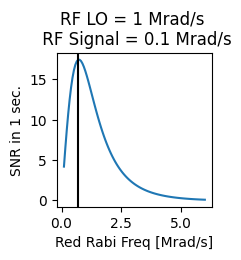

In [8]:
fix, ax = plt.subplots(figsize = (2,2))
ax.plot(param_mesh_final[0], snrs_final)
ax.set_xlabel("Red Rabi Freq [Mrad/s]")
ax.set_ylabel("SNR in 1 sec.")
ax.set_title('RF LO = 1 Mrad/s \n RF Signal = 0.1 Mrad/s')
ax.axvline(blue_rabi_1/np.sqrt(2),0,3, color = 'k')

## 2D Optimum - Fnd Optimized $\Omega_p$ and $\Omega_c$ for best SNR

We can also calculate the SNR versus many different axis. Here we calculate versus both the probe and coupling Rabi frequencies.

In [9]:
couple = {'states': (1,2), 'rabi_frequency': blue_rabi, 'detuning': 0, 'label':'couple'}

Rb_sensor.add_couplings(probe,couple, rf)

In [10]:
snrs, param_mesh = rq.get_snr(Rb_sensor, param_label = 'rf_rabi_frequency', phase_quadrature = True)

In [11]:
Rb_sensor.axis_labels()

['probe_rabi_frequency', 'couple_rabi_frequency', 'rf_rabi_frequency']

In [12]:
snrs_final = snrs[:,:,1]
param_mesh_final=np.array(param_mesh)[:,:,:,1]

In [13]:
predictedOptimumProbe = np.sqrt(gam[1,0]*gam[2,0])
predictedOptimumCouple = np.sqrt(2*gam[1,0]*gam[2,0])
print(f'Predicted optimum probe Rabi frequency: {predictedOptimumProbe:.3f} Mrad/s')
print(f'Predicted optimum coupling Rabi frequency: {predictedOptimumCouple:.3f} Mrad/s')

Predicted optimum probe Rabi frequency: 0.775 Mrad/s
Predicted optimum coupling Rabi frequency: 1.095 Mrad/s


We plot the SNR versus both Rabi frequencies using a contour plot. We have overlaid the analytic predictions for the optimal SNR. Compare Figure 5(a) of Meyer et. al.

Text(60, -10, 'prediction from\narXiv:2105.10494 Eqs 12,13')

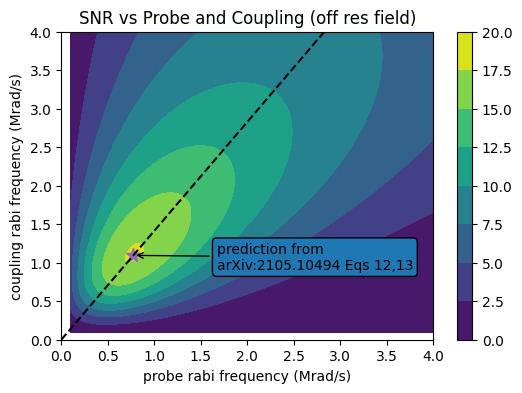

In [14]:
fig, ax = plt.subplots(figsize = (6,4))
CS = ax.contourf(param_mesh_final[0], param_mesh_final[1], snrs_final)
fig.colorbar(CS)
ax.set_xlabel('probe rabi frequency (Mrad/s)')
ax.set_ylabel('coupling rabi frequency (Mrad/s)')
ax.plot(predictedOptimumProbe, predictedOptimumCouple, '*', color = 'C4', markersize = 10)
ax.plot([0,10,20], [0,np.sqrt(2)*10,np.sqrt(2)*20 ],'--', color = 'black')
ax.set_title("SNR vs Probe and Coupling (off res field)")
ax.set_ylim((0,4))
ax.set_xlim((0,4))

ax.annotate("prediction from\narXiv:2105.10494 Eqs 12,13",
           xy=(predictedOptimumProbe, predictedOptimumCouple), xycoords='data',
           xytext=(60,-10), textcoords='offset points',
           arrowprops=dict(arrowstyle='->'),
            bbox=dict(boxstyle='round')
           )


In [15]:
rq.about()


        Rydiqule
    
Rydiqule Version:     2.2.0.dev49+g12b02b0ad.d20260120
Installation Path:    ~\src\rydiqule_public\src\rydiqule

      Dependencies
    
NumPy Version:        2.2.6
SciPy Version:        1.15.3
Matplotlib Version:   3.10.8
ARC Version:          3.9.0
Python Version:       3.10.19
Python Install Path:  ~\src\rydiqule_public\.venv\Scripts
Platform Info:        Windows (AMD64)
CPU Count and Freq:   16 @ 3.91 GHz
Total System Memory:  256 GB
